# 07. PyTorch experiment tracking

### Different ways to track machine learning experiments

|Method	|Setup	|Pros	|Cons	|Cost|
|-|-|-|-|-|
|Python dictionaries, CSV files, print outs|	None	|Easy to setup, runs in pure Python	|Hard to keep track of large numbers of experiments	|Free|
|TensorBoard	|Minimal, install tensorboard|	Extensions built into PyTorch, widely recognized and used, easily scales.|	User-experience not as nice as other options.|	Free|
|Weights & Biases Experiment Tracking	|Minimal, install wandb, make an account	|Incredible user experience, make experiments public, tracks almost anything.	|Requires external resource outside of PyTorch.|	Free for personal use|
|MLFlow	|Minimal, install mlflow and start tracking	|Fully open-source MLOps lifecycle management, many integrations.|	Little bit harder to setup a remote tracking server than other services.	|Free|


## 0. Getting setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms
from torchinfo import summary

device = "mps" if torch.mps.is_available() else "cpu"

### get a helper function to set seeds

In [2]:
# Set seeds
def set_seeds(seed: int=37):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.mps.manual_seed(seed)

## 1. Get data

In [3]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

To transform our images into tensors, we can use:

Manually created transforms using `torchvision.transforms`.
1. Automatically created transforms using `torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT`.transforms().
2. Where MODEL_NAME is a specific torchvision.models architecture, MODEL_WEIGHTS is a specific set of pretrained weights and DEFAULT means the "best available weights".


### 2.1 Create DataLoaders using manually created transforms

In [4]:
from going_modular import data_setup
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

print(f"Manually created transforms:{manual_transforms}")

# create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=32,
    num_workers=0
)

train_dataloader, test_dataloader, class_names

Manually created transforms:Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x34368a630>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

In [5]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path /"test"

# Setup pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transform from weights
automatic_transforms = weights.transforms()
print(f"Automatically created transforms:{automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms,
    batch_size=32,
    num_workers=0
)

train_dataloader, test_dataloader, class_names

Automatically created transforms:ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x34446f9b0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [6]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [7]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False

# let's set the seeds
set_seeds()

# update the classifier head to suit our problem
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device=device)

next(model.parameters()).device

device(type='mps', index=0)

## 4. Train model and track results

In [8]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [9]:
from torch.utils.tensorboard import SummaryWriter
# Create a writer with all default settings
writer = SummaryWriter()

In [10]:
import tensorboard
print(tensorboard.__version__)

2.19.0


In [11]:
from going_modular.engine import train
# Train model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device,
                writer=writer)

/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]/Users/vinsmoke/miniconda3/envs/deep-learning/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0308 | train_acc: 0.4688 | test_loss: 0.8086 | test_acc: 0.8239


 20%|██        | 1/5 [00:03<00:14,  3.50s/it]

Epoch: 2 | train_loss: 0.9198 | train_acc: 0.6211 | test_loss: 0.6697 | test_acc: 0.7822


 40%|████      | 2/5 [00:06<00:08,  2.93s/it]

Epoch: 3 | train_loss: 0.7271 | train_acc: 0.8359 | test_loss: 0.6659 | test_acc: 0.8551


 60%|██████    | 3/5 [00:08<00:05,  2.77s/it]

Epoch: 4 | train_loss: 0.7183 | train_acc: 0.7891 | test_loss: 0.6674 | test_acc: 0.8551


 80%|████████  | 4/5 [00:11<00:02,  2.70s/it]

Epoch: 5 | train_loss: 0.6155 | train_acc: 0.8125 | test_loss: 0.5483 | test_acc: 0.8759


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


## 5. View our model's results in tensorboard

The SummaryWriter() class stores our model's results in a directory called runs/ in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You can view TensorBoard in a number of ways:

|Code environment	|How to view TensorBoard	|Resource|
|-|-|-|
|VS Code (notebooks or Python scripts)	|Press SHIFT + CMD + P to open the Command Palette and search for the command "Python: Launch TensorBoard".	|VS Code Guide on TensorBoard and PyTorch|
|Jupyter and Colab Notebooks	|Make sure TensorBoard is installed, load it with %load_ext tensorboard and then view your results with %tensorboard --logdir DIR_WITH_LOGS.	|torch.utils.tensorboard and Get started with TensorBoard|

## 6.0 Create a helper function to build `SummaryWriter()` instance

In [12]:
from torch.utils.tensorboard import SummaryWriter


def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> SummaryWriter:
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [13]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_10_percent/effnetb0/5_epochs...


### 6.1 Update the train() function to include a writer parameter

see `going_modular.engine.train`

## 7. Setting up a series of modelling experiments
### 7.1 What kind of experiments should you run

Every hyperparameters stands as a starting point for a different experiment:
* Change the number of epochs.
* Change the number of layers/hidden units.
* Change the amount of data.
* Change the learning rate.
* Try different kinds of data augmentation.
* Choose a different model architecture.

### 7.2 What experiments are we going to run?
Our goal is to imporove the model powering Foodvision Mini without it getting too big.

Let's try a combination of:

1. A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
2. A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
3. A different training time (5 epochs vs. 10 epochs)

Breaking these down we get:

|Experiment number	|Training Dataset	|Model (pretrained on ImageNet)|	Number of epochs|
|-|-|-|-|
1	|Pizza, Steak, Sushi 10% percent|	EfficientNetB0|	5|
2|	Pizza, Steak, Sushi 10% percent	|EfficientNetB2|	5|
3|	Pizza, Steak, Sushi 10% percent|	EfficientNetB0|	10|
4|	Pizza, Steak, Sushi 10% percent|	EfficientNetB2|	10|
5|	Pizza, Steak, Sushi 20% percent|	EfficientNetB0|	5|
6|	Pizza, Steak, Sushi 20% percent|	EfficientNetB2|	5|
7|	Pizza, Steak, Sushi 20% percent|	EfficientNetB0|	10|
8|	Pizza, Steak, Sushi 20% percent|	EfficientNetB2|	10|

### 7.3 Download different datasets



In [14]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


In [15]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

test_dir = data_10_percent_path / "test"

print(train_dir_10_percent)
print(train_dir_20_percent)
print(test_dir)

data/pizza_steak_sushi/train
data/pizza_steak_sushi_20_percent/train
data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create Dataloaders

In [16]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with imageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225])

# compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [17]:
from going_modular.data_setup import create_dataloaders
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir_10_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=0
)

# Create 10% training and test DataLoaders
train_dataloader_20_percent, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE,
    num_workers=0
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(test_dataloader)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")


Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 3 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

We're going to create two feature extractor models:

1. torchvision.models.efficientnet_b0() pretrained backbone + custom classifier head (EffNetB0 for short).
2. torchvision.models.efficientnet_b2() pretrained backbone + custom classifier head (EffNetB2 for short).

In [18]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# # # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 

#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Number of in_features to final layer of EfficientNetB2: 1408


In [19]:
import torchvision
from torch import nn
# get num out features 
OUT_FEATURES = len(class_names)

# Create an EFFNETB0 feateure extractor
def create_effnetb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device=device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Set the seeds
    set_seeds()

    # changes the classifier layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb0"
    return model

# Create an EFFNETB2 feateure extractor
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device=device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Set the seeds
    set_seeds()

    # changes the classifier layer
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    model.name = "effnetb2"
    return model

In [20]:
effnetb0 = create_effnetb0()
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

In [21]:
effnetb2 = create_effnetb2()
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

### 7.6 Create exoeriments and setup training code

In [22]:
# Create epochs list
num_epochs = [5, 8]

# Create models list
models = ["effnetb0", "effnetb2"]

# create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                    "data_20_percent": train_dataloader_20_percent}

Specifically, let's go through the following steps:

* Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
* Keep track of different experiment numbers (this is mostly for pretty print outs).
* Loop through the train_dataloaders dictionary items for each of the different training DataLoaders.
* Loop through the list of epoch numbers.
* Loop through the list of different model names.
* Create information print outs for the current running experiment (so we know what's happening).
* Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
* Create a new loss function (torch.nn.CrossEntropyLoss()) and optimizer (torch.optim.Adam(params=model.parameters(), lr=0.001)) for each new experiment.
* Train the model with the modified train() function passing the appropriate details to the writer parameter.
* Save the trained model with an appropriate file name to file with save_model() from utils.py.

In [23]:
# %%time
from going_modular.utils import save_model
from going_modular.engine import train

# Set the random seeds
set_seeds(37)

# Keep track of experiments numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    for epochs in num_epochs:
        for model_name in models:
            # create information print out
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs:{epochs}")

            # select the model
            if model_name == "effnetb0":
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            # Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            writer=create_writer(experiment_name=dataloader_name, model_name=model_name, extra=f"{epochs}_epochs")
            # train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=writer)
            
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir="models", model_name=save_filepath)

            print("-"*50+"\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0799 | train_acc: 0.3984 | test_loss: 0.8782 | test_acc: 0.6307


 20%|██        | 1/5 [00:02<00:09,  2.37s/it]

Epoch: 2 | train_loss: 0.8544 | train_acc: 0.8477 | test_loss: 0.7624 | test_acc: 0.7955


 40%|████      | 2/5 [00:04<00:07,  2.40s/it]

Epoch: 3 | train_loss: 0.7951 | train_acc: 0.7109 | test_loss: 0.6922 | test_acc: 0.8864


 60%|██████    | 3/5 [00:07<00:04,  2.40s/it]

Epoch: 4 | train_loss: 0.7117 | train_acc: 0.7734 | test_loss: 0.6429 | test_acc: 0.8561


 80%|████████  | 4/5 [00:09<00:02,  2.40s/it]

Epoch: 5 | train_loss: 0.6486 | train_acc: 0.7656 | test_loss: 0.6335 | test_acc: 0.8665


100%|██████████| 5/5 [00:12<00:00,  2.40s/it]


[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0566 | train_acc: 0.3594 | test_loss: 0.9663 | test_acc: 0.6922


 20%|██        | 1/5 [00:03<00:14,  3.63s/it]

Epoch: 2 | train_loss: 0.8658 | train_acc: 0.7383 | test_loss: 0.8066 | test_acc: 0.8239


 40%|████      | 2/5 [00:06<00:09,  3.22s/it]

Epoch: 3 | train_loss: 0.8455 | train_acc: 0.6797 | test_loss: 0.7573 | test_acc: 0.8551


 60%|██████    | 3/5 [00:09<00:06,  3.13s/it]

Epoch: 4 | train_loss: 0.6883 | train_acc: 0.7695 | test_loss: 0.7665 | test_acc: 0.7841


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7578 | test_loss: 0.7689 | test_acc: 0.7225


100%|██████████| 5/5 [00:15<00:00,  3.10s/it]


[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:8
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_10_percent/effnetb0/8_epochs...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0799 | train_acc: 0.3984 | test_loss: 0.8782 | test_acc: 0.6307


 12%|█▎        | 1/8 [00:02<00:17,  2.48s/it]

Epoch: 2 | train_loss: 0.8544 | train_acc: 0.8477 | test_loss: 0.7624 | test_acc: 0.7955


 25%|██▌       | 2/8 [00:04<00:14,  2.44s/it]

Epoch: 3 | train_loss: 0.7951 | train_acc: 0.7109 | test_loss: 0.6922 | test_acc: 0.8864


 38%|███▊      | 3/8 [00:07<00:12,  2.43s/it]

Epoch: 4 | train_loss: 0.7117 | train_acc: 0.7734 | test_loss: 0.6429 | test_acc: 0.8561


 50%|█████     | 4/8 [00:09<00:09,  2.41s/it]

Epoch: 5 | train_loss: 0.6486 | train_acc: 0.7656 | test_loss: 0.6335 | test_acc: 0.8665


 62%|██████▎   | 5/8 [00:12<00:07,  2.42s/it]

Epoch: 6 | train_loss: 0.5553 | train_acc: 0.9375 | test_loss: 0.5835 | test_acc: 0.8968


 75%|███████▌  | 6/8 [00:14<00:04,  2.42s/it]

Epoch: 7 | train_loss: 0.6126 | train_acc: 0.7695 | test_loss: 0.5504 | test_acc: 0.8864


 88%|████████▊ | 7/8 [00:16<00:02,  2.43s/it]

Epoch: 8 | train_loss: 0.5771 | train_acc: 0.7812 | test_loss: 0.5279 | test_acc: 0.9176


100%|██████████| 8/8 [00:19<00:00,  2.43s/it]


[INFO] Saving model to: models/07_effnetb0_data_10_percent_8_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 4
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs:8
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_10_percent/effnetb2/8_epochs...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0566 | train_acc: 0.3594 | test_loss: 0.9663 | test_acc: 0.6922


 12%|█▎        | 1/8 [00:03<00:22,  3.14s/it]

Epoch: 2 | train_loss: 0.8658 | train_acc: 0.7383 | test_loss: 0.8066 | test_acc: 0.8239


 25%|██▌       | 2/8 [00:06<00:18,  3.13s/it]

Epoch: 3 | train_loss: 0.8455 | train_acc: 0.6797 | test_loss: 0.7573 | test_acc: 0.8551


 38%|███▊      | 3/8 [00:09<00:15,  3.08s/it]

Epoch: 4 | train_loss: 0.6883 | train_acc: 0.7695 | test_loss: 0.7665 | test_acc: 0.7841


 50%|█████     | 4/8 [00:12<00:12,  3.11s/it]

Epoch: 5 | train_loss: 0.6373 | train_acc: 0.7578 | test_loss: 0.7689 | test_acc: 0.7225


 62%|██████▎   | 5/8 [00:15<00:09,  3.07s/it]

Epoch: 6 | train_loss: 0.5874 | train_acc: 0.8906 | test_loss: 0.6968 | test_acc: 0.8466


 75%|███████▌  | 6/8 [00:18<00:06,  3.07s/it]

Epoch: 7 | train_loss: 0.6047 | train_acc: 0.7734 | test_loss: 0.6879 | test_acc: 0.8466


 88%|████████▊ | 7/8 [00:21<00:03,  3.07s/it]

Epoch: 8 | train_loss: 0.5076 | train_acc: 0.9062 | test_loss: 0.5854 | test_acc: 0.8561


100%|██████████| 8/8 [00:24<00:00,  3.07s/it]


[INFO] Saving model to: models/07_effnetb2_data_10_percent_8_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 5
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_20_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5250 | test_loss: 0.7377 | test_acc: 0.8352


 20%|██        | 1/5 [00:03<00:14,  3.57s/it]

Epoch: 2 | train_loss: 0.7160 | train_acc: 0.8229 | test_loss: 0.5984 | test_acc: 0.8769


 40%|████      | 2/5 [00:06<00:10,  3.39s/it]

Epoch: 3 | train_loss: 0.5332 | train_acc: 0.8729 | test_loss: 0.4813 | test_acc: 0.9280


 60%|██████    | 3/5 [00:10<00:06,  3.39s/it]

Epoch: 4 | train_loss: 0.4918 | train_acc: 0.8562 | test_loss: 0.4473 | test_acc: 0.9280


 80%|████████  | 4/5 [00:13<00:03,  3.36s/it]

Epoch: 5 | train_loss: 0.4177 | train_acc: 0.9062 | test_loss: 0.3759 | test_acc: 0.9072


100%|██████████| 5/5 [00:16<00:00,  3.36s/it]


[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:5
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_20_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9866 | train_acc: 0.5292 | test_loss: 0.8185 | test_acc: 0.8248


 20%|██        | 1/5 [00:04<00:17,  4.28s/it]

Epoch: 2 | train_loss: 0.7674 | train_acc: 0.7167 | test_loss: 0.6727 | test_acc: 0.8561


 40%|████      | 2/5 [00:08<00:12,  4.09s/it]

Epoch: 3 | train_loss: 0.6088 | train_acc: 0.8354 | test_loss: 0.6421 | test_acc: 0.8153


 60%|██████    | 3/5 [00:12<00:08,  4.07s/it]

Epoch: 4 | train_loss: 0.4896 | train_acc: 0.8979 | test_loss: 0.5271 | test_acc: 0.8873


 80%|████████  | 4/5 [00:16<00:04,  4.06s/it]

Epoch: 5 | train_loss: 0.4712 | train_acc: 0.8771 | test_loss: 0.5021 | test_acc: 0.8769


100%|██████████| 5/5 [00:20<00:00,  4.06s/it]


[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:8
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_20_percent/effnetb0/8_epochs...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9824 | train_acc: 0.5250 | test_loss: 0.7377 | test_acc: 0.8352


 12%|█▎        | 1/8 [00:03<00:23,  3.37s/it]

Epoch: 2 | train_loss: 0.7160 | train_acc: 0.8229 | test_loss: 0.5984 | test_acc: 0.8769


 25%|██▌       | 2/8 [00:06<00:19,  3.32s/it]

Epoch: 3 | train_loss: 0.5332 | train_acc: 0.8729 | test_loss: 0.4813 | test_acc: 0.9280


 38%|███▊      | 3/8 [00:09<00:16,  3.32s/it]

Epoch: 4 | train_loss: 0.4918 | train_acc: 0.8562 | test_loss: 0.4473 | test_acc: 0.9280


 50%|█████     | 4/8 [00:13<00:13,  3.32s/it]

Epoch: 5 | train_loss: 0.4177 | train_acc: 0.9062 | test_loss: 0.3759 | test_acc: 0.9072


 62%|██████▎   | 5/8 [00:16<00:09,  3.31s/it]

Epoch: 6 | train_loss: 0.4331 | train_acc: 0.8688 | test_loss: 0.3739 | test_acc: 0.9176


 75%|███████▌  | 6/8 [00:19<00:06,  3.29s/it]

Epoch: 7 | train_loss: 0.3393 | train_acc: 0.9104 | test_loss: 0.3413 | test_acc: 0.9072


 88%|████████▊ | 7/8 [00:23<00:03,  3.33s/it]

Epoch: 8 | train_loss: 0.3749 | train_acc: 0.8812 | test_loss: 0.3033 | test_acc: 0.9072


100%|██████████| 8/8 [00:26<00:00,  3.32s/it]


[INFO] Saving model to: models/07_effnetb0_data_20_percent_8_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 8
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of epochs:8
[INFO] Created SummaryWriter, saving to: runs/2025-06-18/data_20_percent/effnetb2/8_epochs...


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9866 | train_acc: 0.5292 | test_loss: 0.8185 | test_acc: 0.8248


 12%|█▎        | 1/8 [00:03<00:27,  3.94s/it]

Epoch: 2 | train_loss: 0.7674 | train_acc: 0.7167 | test_loss: 0.6727 | test_acc: 0.8561


 25%|██▌       | 2/8 [00:07<00:23,  3.93s/it]

Epoch: 3 | train_loss: 0.6088 | train_acc: 0.8354 | test_loss: 0.6421 | test_acc: 0.8153


 38%|███▊      | 3/8 [00:11<00:19,  3.96s/it]

Epoch: 4 | train_loss: 0.4896 | train_acc: 0.8979 | test_loss: 0.5271 | test_acc: 0.8873


 50%|█████     | 4/8 [00:15<00:15,  3.95s/it]

Epoch: 5 | train_loss: 0.4712 | train_acc: 0.8771 | test_loss: 0.5021 | test_acc: 0.8769


 62%|██████▎   | 5/8 [00:19<00:11,  3.94s/it]

Epoch: 6 | train_loss: 0.3936 | train_acc: 0.8958 | test_loss: 0.5078 | test_acc: 0.8769


 75%|███████▌  | 6/8 [00:23<00:07,  3.93s/it]

Epoch: 7 | train_loss: 0.3847 | train_acc: 0.8979 | test_loss: 0.4213 | test_acc: 0.9280


 88%|████████▊ | 7/8 [00:27<00:03,  3.95s/it]

Epoch: 8 | train_loss: 0.3768 | train_acc: 0.9083 | test_loss: 0.4261 | test_acc: 0.8769


100%|██████████| 8/8 [00:31<00:00,  3.95s/it]

[INFO] Saving model to: models/07_effnetb2_data_20_percent_8_epochs.pth
--------------------------------------------------



## 9. Load in the best model and make predictions with it

This is the experiment that used:

* EffNetB2 (double the parameters of EffNetB0)
* 20% pizza, steak, sushi training data (double the original training data)
* 8 epochs (double the original training time)

In [25]:
best_model_path = "models/07_effnetb2_data_20_percent_8_epochs.pth"

best_model = create_effnetb2()

best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [27]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024 * 1024)
print(f"{effnetb2_model_size} MB")

29 MB


In [52]:
import importlib
import going_modular.plot_functions
importlib.reload(going_modular.plot_functions)


<module 'going_modular.plot_functions' from '/Users/vinsmoke/workspace/Deep-Learning-Specialization/pytorch/going_modular/plot_functions.py'>

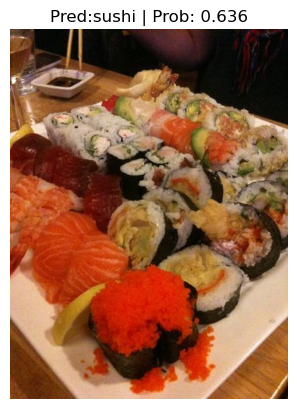

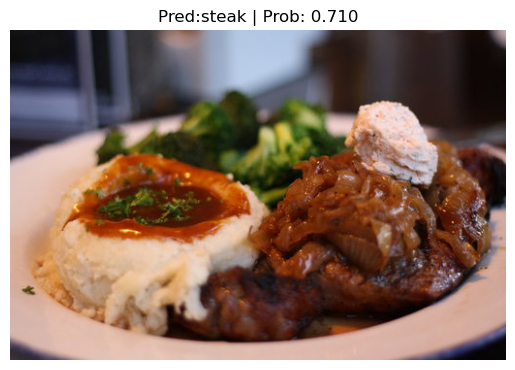

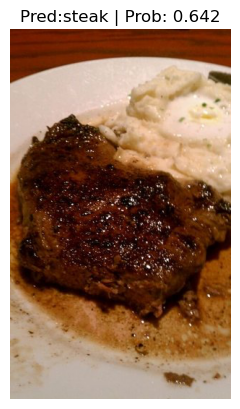

In [54]:
from going_modular.plot_functions import pred_and_plot_image

import random

num_image_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_image_to_plot)

for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names)

### 9.1 Predict on a custom image with the best model

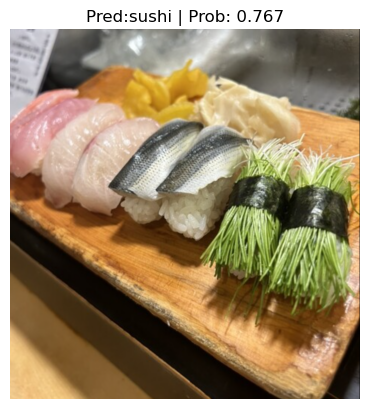

In [61]:
from going_modular.plot_functions import pred_and_plot_image

import random

custom_image_path = Path("data/custom-image-sushi.jpeg")

pred_and_plot_image(model=best_model,
                    image_path=custom_image_path,
                    class_names=class_names)